# MBTI Project - First Model

By Nan Lin

* added a folder named firstModel and chaged data dir of every notebook from data/..csv to ../data/..csv
-  EDA: 
    What we can tell from the violinplot? Should we remove these two plots from our EDA part?
    Similarly, from word cloud, it seems all types have similar dominant words
    Setiment Score distribution is highly skewed? Should we just remove this feature, or any other ways to normalize this feature

- Featuring Engineering:
    - Count Vectors as featuress or TF-IDF Vectors as features(Word-level TFIDF, N-gram Level TFIDF, Character Level TFIDF?)
    - Text, NLP based features(word count, upper case count, number count, etc)
    - Topic Modeling? seems commonly used in NLP related projects. reference: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
* I vs E, N vs S are highly imbalanced, which will affect the accuracy. Do we need to apply some techiniques mentioned here?
reference: https://elitedatascience.com/imbalanced-classes

- Modeling:
* due to limited time, just set up function with vectorizer parameter and built NB classifier for three different vectorizers(Count, Word level TFIDF, N-gram TFIDF)
    - Naive Bayes Classifer
    - Linear Classifier
    - SVM
    - Baggings
    - Boosting Models
* keep at least one well tuned model of each classifier for further comparison and analysis

- Performance Metrics
    - Accuracy, F1-score, ROC-AUC which one should we prioritize for our project? 
    -  From the production perspective, we can add matrics like computation cost, time complexity

In [1]:
reset -fs

In [4]:
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
# pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# pip install wordcloud
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string 
import re
from collections import Counter
import numpy as np
plt.style.use('fivethirtyeight')

In [6]:
mbti = pd.read_csv('../data/mbti_1.csv') 

In [9]:
# Types per category
# analyze types by sub-category may be easier
mbti['EorI']= mbti['type'].apply(lambda x:x[0])
mbti['NorS']= mbti['type'].apply(lambda x:x[1])
mbti['TorF']= mbti['type'].apply(lambda x:x[2])
mbti['JorP']= mbti['type'].apply(lambda x:x[3])

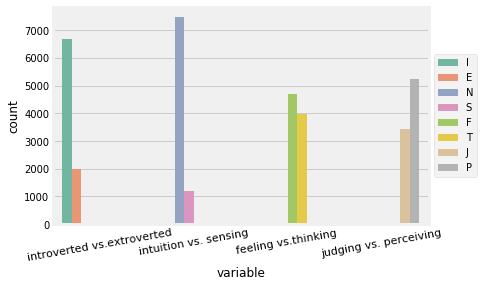

In [10]:
ax = sns.countplot(x='variable',hue='value',data=pd.melt(mbti.iloc[:,2:]),palette="Set2")
ax.set_xticklabels(["introverted vs.extroverted", "intuition vs. sensing", 
                    "feeling vs.thinking ", "judging vs. perceiving", 
                    ], rotation=10, fontsize=11)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Imbalanced class: I vs E, N vs S. Some advanced techniques like resampling methods may be needed later to handle imbalanced classes.

#### Their last 50 posts:
Focus on some statistics(mean,variance) of posts

words they averagely used in per comment (including everything rather than spaces)

In [11]:
mbti['avg_comment_length'] = mbti['posts'].apply(lambda x: len(x.split())/50)
mbti['comment_length_var'] = mbti['posts'].apply(lambda x: np.var([len(sentence.split()) for sentence in x.split('|||')]))

In [10]:
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,19.34,196.4576


## Data preprocessing

### Define a function for cleaning the posts:
- Remove "|||" and links and punctuations and MBTI words(As u see in the text, real names user referring to are changed to MBTI type)
- Lowercase
- Lemmatize word, remove stop words and words less than 3 characters (lemmatizing would be better than stemming but takes more time)

In [16]:
# get 16 types of personality list for removing MBTI words in the following function
types = list(mbti.iloc[:,0].unique())
types = [t.lower() for t in types]

In [17]:
def post_preprocess(df):
    i = 0
    post_list = []
    length = len(df)
    lemmatiser = WordNetLemmatizer() # or use PorterStemmer(), if want to run faster
    print('Processing... Be patient')
    
    for row in df.iterrows():
        # Progress bar
        i+=1
        if (i % 500 == 0 or i == length):
            print(f"Progress bar：{round(i/length*100)}%")
        # clean the posts
        # extract the post
        posts = row[1].posts
        # remove ||| 
        posts = re.sub(r'\|\|\|',' ',posts)
        # remove all links and transform to lower case
        posts = re.sub(r'http[\S]*', '', posts).lower()
        ### ??? ###
        posts = re.sub("[^a-z\s]", ' ', posts)
        # stemmer? remove english words
        posts = ' '.join([lemmatiser.lemmatize(w) for w in posts.split(' ') if w not in stopwords.words('english')])
        # remove mentioned personality types inside the post
        for t in types:
            posts = posts.replace(t,'')
        # post container: list
        post_list.append(posts)
        
    return np.array(post_list)      

In [82]:
# Here I takes FOREVER to run it T_T
# import nltk
# nltk.download('wordnet')
# processed_post = post_preprocess(mbti)

In [30]:
# save time, run this to load the clean post
processed_post = pd.read_csv('mbti_preprocessed_1.csv')
processed_post.drop('Unnamed: 0',axis=1,inplace=True)
processed_post.head()

,type,posts,processed_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play pr...
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring positi...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation day esoteric ...
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approachi...


## Modeling from word vectors as features

In [27]:
processed_post = pd.read_csv("../data/mbti_preprocessed_1.csv")

#### Added target columns to the processed dataset

In [35]:
processed_post['EorI']= mbti['type'].apply(lambda x:x[0])
processed_post['NorS']= mbti['type'].apply(lambda x:x[1])
processed_post['TorF']= mbti['type'].apply(lambda x:x[2])
processed_post['JorP']= mbti['type'].apply(lambda x:x[3])

processed_post.head(3)

,Unnamed: 0,type,posts,processed_posts,EorI,NorS,TorF,JorP
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play pr...,I,N,F,J
1,1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring positi...,E,N,T,P
2,2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing...,I,N,T,P


In [36]:
# saved as processed data with personality breakdown
processed_post.to_csv("../data/ProceesdBreakdown.csv",index=False)

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from numpy import mean
import warnings
warnings.filterwarnings('ignore')

In [77]:
def base_model_vector(model,vectorizer, X, target, nsplits=4):
    kf = StratifiedShuffleSplit(n_splits=nsplits, random_state=420)

    for col in np.array(target.columns):
        print(f"This is the training for {col}:")
        y = target[col]
        all_fscores = []
        all_accuracies = []
        for train, test in kf.split(X,y):
            X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
            probs = np.ones((len(y_test), 16))
            
            # add vectorizer
            vectorizer.fit(X)
            train_features = vectorizer.transform(X_train)
            test_features = vectorizer.transform(X_test)
            
            model.fit(train_features, y_train)
            
            preds = model.predict(test_features)
            fscore = f1_score(y_test, preds, average='weighted')
            all_fscores.append(fscore)
            accuracy = accuracy_score(preds, y_test)
            all_accuracies.append(accuracy)
            vectorizer_name = str(vectorizer).split('(')[0]
            model_name = str(model).split('(')[0]
            print(f'{model_name} {vectorizer_name} F1-score: {fscore}; Accuracy: {accuracy}')
        print(f'Average F1-score: {mean(all_fscores)}; Average Accuracy: {mean(all_accuracies)}')

### Naive Bayes on Count Vector

In [78]:
X = processed_post['processed_posts']
target = processed_post.iloc[:,4:8]

# Naive Bayes on Count Vector
vectorizer1 = CountVectorizer(stop_words='english',analyzer='word',input='content', 
                                 decode_error='ignore', max_df=0.48,min_df=5,
                                 token_pattern=r'\w{1,}')
model1 = MultinomialNB()
base_model_vector(model1,vectorizer,X,target)


This is the training for EorI:
MultinomialNB CountVectorizer F1-score: 0.7640309123805891; Accuracy: 0.7638248847926268
MultinomialNB CountVectorizer F1-score: 0.7348365204194817; Accuracy: 0.738479262672811
MultinomialNB CountVectorizer F1-score: 0.7529473648100079; Accuracy: 0.7523041474654378
MultinomialNB CountVectorizer F1-score: 0.7733901363174354; Accuracy: 0.7741935483870968
Average F1-score: 0.7563012334818784; Average Accuracy: 0.7572004608294931
This is the training for NorS:
MultinomialNB CountVectorizer F1-score: 0.8474636834064505; Accuracy: 0.8559907834101382
MultinomialNB CountVectorizer F1-score: 0.8303957034710504; Accuracy: 0.8341013824884793
MultinomialNB CountVectorizer F1-score: 0.8290542023260918; Accuracy: 0.8341013824884793
MultinomialNB CountVectorizer F1-score: 0.821210364739576; Accuracy: 0.8271889400921659
Average F1-score: 0.8320309884857922; Average Accuracy: 0.8378456221198157
This is the training for TorF:
MultinomialNB CountVectorizer F1-score: 0.78906

### Naive Bayes on TF IDF Vectors

In [81]:
## Due to limited time don't have much time to tune the vectorizer, would iterately update vectoruzer parameters to make better performance

vectorizer2 = vectorizer = TfidfVectorizer(max_df=.8, min_df=25)
model1 = MultinomialNB()
base_model_vector(model1,vectorizer2,X,target)

This is the training for EorI:
MultinomialNB TfidfVectorizer F1-score: 0.6693788402457758; Accuracy: 0.7695852534562212
MultinomialNB TfidfVectorizer F1-score: 0.672107601711343; Accuracy: 0.7707373271889401
MultinomialNB TfidfVectorizer F1-score: 0.6693788402457758; Accuracy: 0.7695852534562212
MultinomialNB TfidfVectorizer F1-score: 0.672107601711343; Accuracy: 0.7707373271889401
Average F1-score: 0.6707432209785593; Average Accuracy: 0.7701612903225806
This is the training for NorS:
MultinomialNB TfidfVectorizer F1-score: 0.7977597298900396; Accuracy: 0.8617511520737328
MultinomialNB TfidfVectorizer F1-score: 0.7977597298900396; Accuracy: 0.8617511520737328
MultinomialNB TfidfVectorizer F1-score: 0.7977597298900396; Accuracy: 0.8617511520737328
MultinomialNB TfidfVectorizer F1-score: 0.7977597298900396; Accuracy: 0.8617511520737328
Average F1-score: 0.7977597298900396; Average Accuracy: 0.8617511520737328
This is the training for TorF:
MultinomialNB TfidfVectorizer F1-score: 0.75808

### Naive Bayes on N-gram TF IDF Vectors

In [83]:
### Naive Bayes on Ngram Level TF IDF Vectors
### took much longer than previous two vectorizers
vectorizer3 = TfidfVectorizer(max_df=.8, min_df=25,norm=None, ngram_range=(3,3))
model1 = MultinomialNB()
base_model_vector(model1,vectorizer3,X,target)

This is the training for EorI:
MultinomialNB TfidfVectorizer F1-score: 0.6574788219119454; Accuracy: 0.6394009216589862
MultinomialNB TfidfVectorizer F1-score: 0.6503352635621311; Accuracy: 0.6359447004608295
MultinomialNB TfidfVectorizer F1-score: 0.6641322428147762; Accuracy: 0.6509216589861752
MultinomialNB TfidfVectorizer F1-score: 0.6695189923514896; Accuracy: 0.6543778801843319
Average F1-score: 0.6603663301600856; Average Accuracy: 0.6451612903225807
This is the training for NorS:
MultinomialNB TfidfVectorizer F1-score: 0.7634600614439323; Accuracy: 0.7442396313364056
MultinomialNB TfidfVectorizer F1-score: 0.752314539128537; Accuracy: 0.7361751152073732
MultinomialNB TfidfVectorizer F1-score: 0.7554300273042629; Accuracy: 0.7373271889400922
MultinomialNB TfidfVectorizer F1-score: 0.7739821094844559; Accuracy: 0.7672811059907834
Average F1-score: 0.761296684340297; Average Accuracy: 0.7462557603686636
This is the training for TorF:
MultinomialNB TfidfVectorizer F1-score: 0.55264